# German Intro ML Tutorial

In diesem Tutorial werden wir verschiedene Machine-Learning-Techniken auf Schwingungsdaten anwenden.
Unser Ziel ist es, den Zustand einer Maschine basierend auf Vibrationsdaten zu klassifizieren und bestimmte Werte vorherzusagen.

**Inhalt:**
1. **Feature Engineering**: Vorbereitung der Daten.
2. **Supervised Learning (Klassifikation)**: Vorhersage von Kategorien (z.B. 'Normal' vs. 'Hoch').
3. **Supervised Learning (Regression)**: Vorhersage von kontinuierlichen Werten.
4. **Unsupervised Learning**: Finden von Mustern ohne Labels.
5. **Deep Learning Showcase**: Ein kurzer Einblick in neuronale Netze.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Daten laden
file_path = 'vibration_messung_2025-10-15_1704-1737.csv'
df = pd.read_csv(file_path)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
print("Daten geladen:")
print(df.head())

Daten geladen:
                                    sensor_id  wert
time                                               
2025-10-15 17:04:00.004000+02:00  AnalogValue    67
2025-10-15 17:04:00.024000+02:00  AnalogValue     0
2025-10-15 17:04:00.034000+02:00  AnalogValue     0
2025-10-15 17:04:00.044000+02:00  AnalogValue     0
2025-10-15 17:04:00.054000+02:00  AnalogValue     0


## Feature Engineering

Rohdaten sind oft verrauscht. Wir erstellen **rollierende Statistiken** (Mittelwert, Standardabweichung, Min, Max) über ein Zeitfenster.
Dies glättet die Daten und macht Trends für das Modell sichtbarer.

Zusätzlich erstellen wir ein **Label** für das Supervised Learning: Wenn der Mittelwert über 1000 liegt, klassifizieren wir dies als 'High Vibration' (1), sonst als 'Normal' (0).


In [12]:
# Rollierende Statistiken berechnen (Fenstergröße 50)
window_size = 50
df_features = df[['wert']].rolling(window=window_size).agg(['mean', 'std', 'min', 'max']).dropna()
df_features.columns = df_features.columns.droplevel(0)

# Target Label erstellen: "High" Vibration (> 1000) vs "Normal"
# Wir nutzen den Mittelwert des Fensters für das Label
threshold = 1000
df_features['label'] = (df_features['mean'] > threshold).astype(int)

print("Features und Labels:")
print(df_features.head())
print(f"Verteilung der Labels:\n{df_features['label'].value_counts()}")

Features und Labels:
                                   mean        std  min    max  label
time                                                                 
2025-10-15 17:04:00.544000+02:00  45.60  58.416520  0.0  210.0      0
2025-10-15 17:04:00.554000+02:00  44.26  58.683450  0.0  210.0      0
2025-10-15 17:04:00.574000+02:00  44.28  58.668227  0.0  210.0      0
2025-10-15 17:04:00.584000+02:00  45.80  58.481813  0.0  210.0      0
2025-10-15 17:04:00.594000+02:00  45.80  58.481813  0.0  210.0      0
Verteilung der Labels:
label
0    159523
1      1294
Name: count, dtype: int64


## Supervised Learning: Klassifikation

Hier trainieren wir Modelle, um zu entscheiden, ob ein Zustand kritisch ist oder nicht.
Wir vergleichen verschiedene Algorithmen:
*   **Random Forest**: Ein Ensemble aus vielen Entscheidungsbäumen. Sehr robust.
*   **Support Vector Machine (SVM)**: Versucht, eine optimale Trennlinie zwischen den Klassen zu finden.
*   **K-Nearest Neighbors (KNN)**: Klassifiziert basierend auf der Ähnlichkeit zu den Nachbarn.
*   **Gradient Boosting**: Baut schrittweise Bäume auf, um Fehler der vorherigen zu korrigieren.


Random Forest Accuracy: 1.0000
SVM Accuracy: 0.9981
KNN Accuracy: 0.9988
Gradient Boosting Accuracy: 1.0000


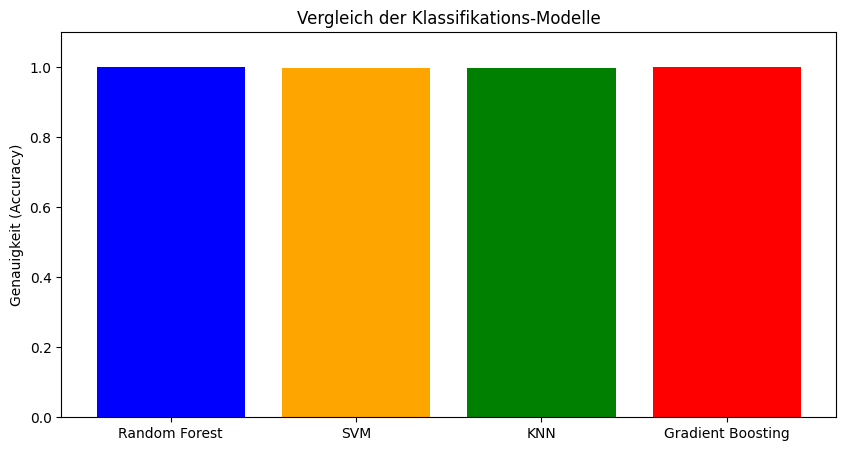

In [13]:
# Bibliotheken importieren
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Daten vorbereiten
X = df_features[['mean', 'std', 'min', 'max']]
y = df_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Modelle initialisieren
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Training und Evaluierung
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# Vergleich
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Vergleich der Klassifikations-Modelle')
plt.ylabel('Genauigkeit (Accuracy)')
plt.ylim(0, 1.1)
plt.show()


## Supervised Learning: Regression

Bei der Regression wollen wir keinen Zustand (Klasse), sondern einen **konkreten Zahlenwert** vorhersagen.
Aufgabe: Wir versuchen, den **Mittelwert ('mean')** basierend auf den anderen Features ('std', 'min', 'max') vorherzusagen.

Modelle:
*   **Linear Regression**: Sucht einen linearen Zusammenhang.
*   **Decision Tree Regressor**: Ein Entscheidungsbaum für Zahlenwerte.
*   **Random Forest Regressor**: Ein Ensemble von Entscheidungsbäumen für kontinuierliche Werte.


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Clean Data First
cols = ['std', 'min', 'max', 'mean']
df_clean = df_features[cols].replace([np.inf, -np.inf], np.nan).dropna()

X_reg = df_clean[['std', 'min', 'max']]
y_reg = df_clean['mean']

# 2. Split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
)

# 3. Optimized Regressors
regressors = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(
        n_estimators=20, 
        max_depth=10, 
        n_jobs=-1, 
        random_state=42
    )
}

print(f"Starting training on {len(X_train_r)} samples...")

for name, model in regressors.items():
    print(f"Processing {name}...", end=" ")
    model.fit(X_train_r, y_train_r)
    y_pred_r = model.predict(X_test_r)
    mse = mean_squared_error(y_test_r, y_pred_r)
    r2 = r2_score(y_test_r, y_pred_r)
    print(f"Done. MSE: {mse:.2f}, R2: {r2:.4f}")


Starting training on 128653 samples...
Processing Linear Regression... Done. MSE: 610.27, R2: 0.9871
Processing Decision Tree... Done. MSE: 608.76, R2: 0.9871
Processing Random Forest... Done. MSE: 510.30, R2: 0.9892


## Unsupervised Learning: K-Means Clustering

Hier haben wir keine Labels. Der Algorithmus versucht selbstständig, Gruppen (Cluster) in den Daten zu finden.


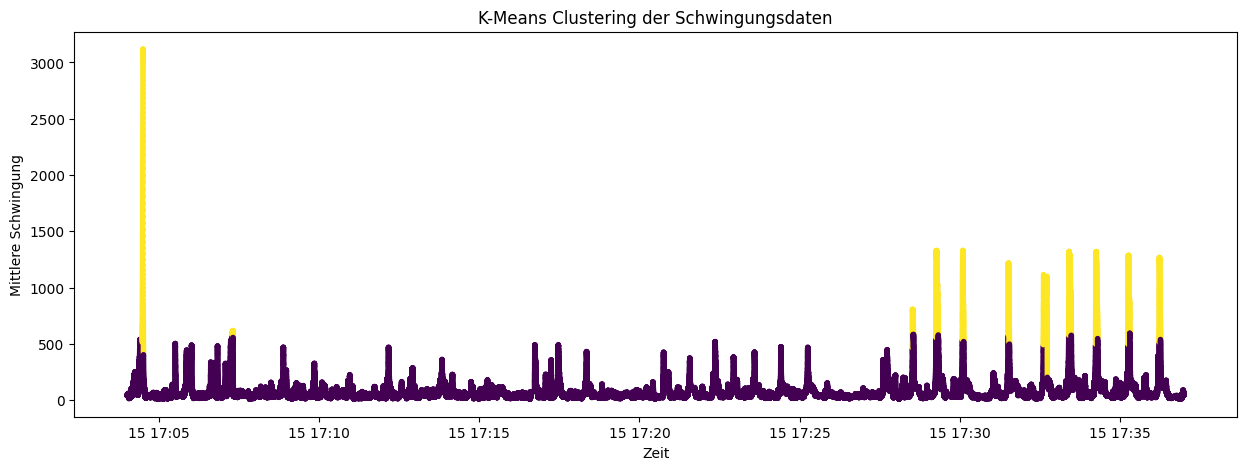

In [15]:
# Daten skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means trainieren (wir erwarten 2 Cluster: Normal und Hoch)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Visualisierung
plt.figure(figsize=(15, 5))
plt.scatter(df_features.index, df_features['mean'], c=clusters, cmap='viridis', marker='.')
plt.title('K-Means Clustering der Schwingungsdaten')
plt.xlabel('Zeit')
plt.ylabel('Mittlere Schwingung')
plt.show()

## Deep Learning Showcase

**Hinweis**: Für strukturierte Daten (Tabellen) wie diese sind klassische ML-Modelle (wie Random Forest oder Gradient Boosting) oft **besser, schneller und einfacher** zu trainieren als Deep Learning.
Deep Learning glänzt vor allem bei unstrukturierten Daten wie Bildern, Audio oder komplexem Text.

Hier zeigen wir trotzdem kurz, wie ein einfaches neuronales Netz (MLP) mit Keras erstellt wird.


In [16]:
# Daten skalieren (MinMax für NN oft besser)
scaler_nn = MinMaxScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn = scaler_nn.transform(X_test)

# Modell erstellen
mlp_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
history_mlp = mlp_model.fit(X_train_nn, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluierung
loss, accuracy = mlp_model.evaluate(X_test_nn, y_test)
print(f"MLP Test Accuracy: {accuracy:.4f}")

Epoch 1/5
3217/3217 [==============================] - 14s 4ms/step - loss: 0.0233 - accuracy: 0.9988 - val_loss: 0.0047 - val_accuracy: 0.9998
Epoch 2/5
3217/3217 [==============================] - 13s 4ms/step - loss: 1.3190e-04 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9910
Epoch 3/5
3217/3217 [==============================] - 13s 4ms/step - loss: 1.6261e-04 - accuracy: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9957
Epoch 4/5
3217/3217 [==============================] - 13s 4ms/step - loss: 1.8156e-04 - accuracy: 0.9999 - val_loss: 0.0044 - val_accuracy: 0.9977
Epoch 5/5
1006/1006 [==============================] - 2s 2ms/step - loss: 0.0101 - accuracy: 0.9956
MLP Test Accuracy: 0.9956
